#Predicting the West Nile Virus in Chicago

This notebook presents an analysis of incidents of the West Nile Virus (WNV) in Chicago during the years 2007–2013 along with some preliminary modeling work. 

Our inputs are three different data sets, courtesy of a [Kaggle competition](https://www.kaggle.com/c/predict-west-nile-virus/). First, we have records of mosquito trap events, with information on the date of a trap event, the location, the species of mosquito trapped, the number of mosquitos trapped, and whether any of those mosquitos carried WNV. Second, we have daily data on a variety of weather variables for the Chicago area during the same time period. Finally, we have data on mosquito spray efforts undertaken by the city of Chicago.

A rough outline for this notebook is as follows:

* Data overview and univariate exploratory analysis
* Multivariate analysis
* Feature extraction and transformation
* Model development
* Further iteration

-----
## Setup

In [1]:
# Import some necessary packages
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline

In [2]:
# Set seaborn defaults
sns.set_style("darkgrid")
sns.set_palette("muted")

In [3]:
# Load the data sets
# for weather data, missing values are coded as "M" and trace precipitation as "T

trap_training_data = pd.read_csv("../input/train.csv")
weather_data = pd.read_csv("../input/weather.csv", na_values=["M", "T"])
spray_data = pd.read_csv("../input/spray.csv")

----
## Exploratory data analysis: one variable

Let's start by looking at each data source and some variables of interest.

###Trap data

In [4]:
# Take a peek at the data
trap_training_data.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [5]:
# Convert dates to datetime objects
trap_training_data["Date"] = pd.to_datetime(trap_training_data["Date"].values)

In [6]:
# Get summary stats
trap_training_data[["Date", "Species", "Trap", 
                    "NumMosquitos", "WnvPresent"]].describe(include="all")

,Date,Species,Trap,NumMosquitos,WnvPresent
count,10506,10506,10506,10506.000000,10506.000000
unique,95,7,136,NaN,NaN
top,2007-08-01 00:00:00,CULEX PIPIENS/RESTUANS,T900,NaN,NaN
freq,551,4752,750,NaN,NaN
first,2007-05-29 00:00:00,NaN,NaN,NaN,NaN
last,2013-09-26 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.853512,0.052446
std,NaN,NaN,NaN,16.133816,0.222936
min,NaN,NaN,NaN,1.000000,0.000000
25%,NaN,NaN,NaN,2.000000,0.000000


We can record some initial observations of the trap data: 

* There are $10^4$ records but only 95 unique dates over a seven-year period.
* Address, Street, and AddressNumberAndStreet look fairly unstructured and difficult to work with.
* There are only 7 species of mosquito. One species, C. Pipiens/Restuans, accounts for almost half of the records.
* There are 136 distinct traps.
* The maximum number of species per trap is 50. This, we are told, is an artifact of how the data were collected. If more than 50 mosquitos appear in a trap, that record gets broken out into multiple records.
* West Nile is not common. In only 5% of trap events are there mosquitos with WNV (i.e. WnvPresent == 1). We are dealing with unbalanced classes.

Let's see how much data we're missing.

In [7]:
# Proportion of missing data per column
trap_training_data.isnull().sum(axis=0) / len(trap_training_data) * 1.0

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: float64

Since there's no missing data, we can look more carefully at certain variables in the trap data set.

#### Date

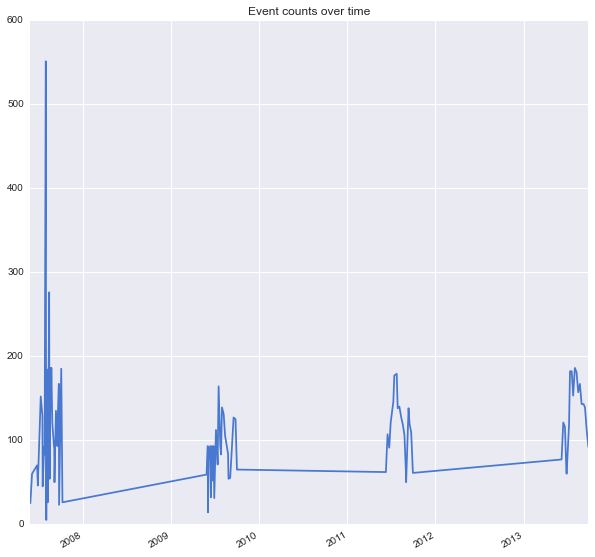

In [8]:
# Distribution of records over time
figsize(10,10)
trap_training_data["Date"].value_counts().plot()
plt.title("Event counts over time")

We see records in ~100-day chunks rougly every two years. So it appears that records were collected during the warm months, when one would expect mosquitos to be in a city. (The gaps every other year are where our testing data resides.)

We also see that most days have 200 or fewer trap records, though there are days toward the start of the record keeping with an inordinately large number of trap records. Within each year, it looks like there are peaks toward the middle of the summer. 

Let's take a year-by-year look.

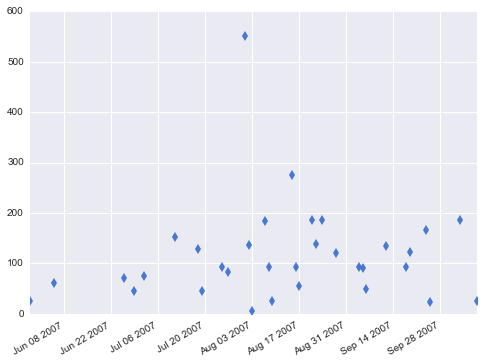

In [9]:
# Events for 2007
figsize(8, 6)
trap_training_data[trap_training_data.Date.dt.year == 2007].Date.value_counts().plot(style='d')

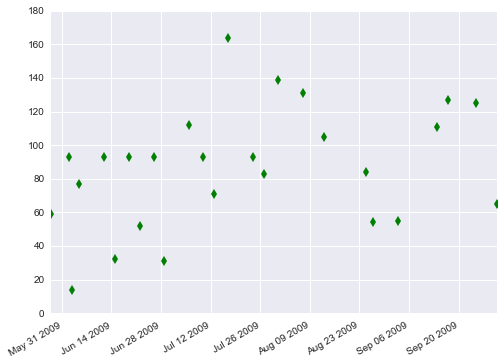

In [10]:
# Events for 2009
trap_training_data[trap_training_data.Date.dt.year == 2009].Date.value_counts().plot(style='gd')

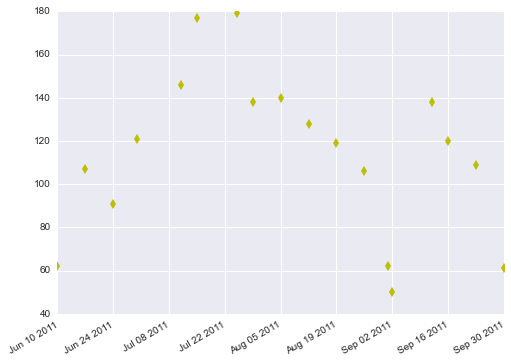

In [11]:
# Events for 2011
trap_training_data[trap_training_data.Date.dt.year == 2011].Date.value_counts().plot(style='yd')

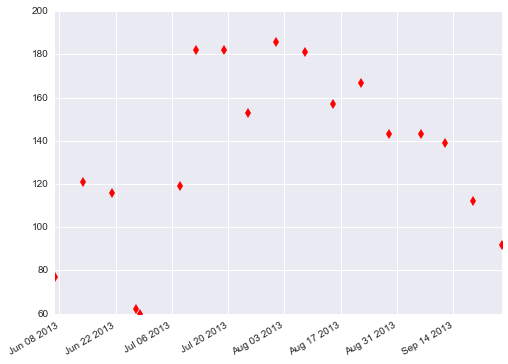

In [12]:
# Events for 2013 
trap_training_data[trap_training_data.Date.dt.year == 2013].Date.value_counts().plot(style='rd')

Most of the dates with trap records are non-contiguous, which complicates any time series analysis that we might want to do. In 2011 and 2013, the trap events seem almost, but not quite, regularly spaced, as if traps were checked regularly and records logged only then. In other years, there is no apparent periodicity, and the randomness of the dates seems like it might reflect actual mosquito abundances. (We can't make assumptions one way or the other, of course.)

Note, too, that since there are $10^3$ events and only 95 unique days, there must be many events on the same day.

In [13]:
datesum, datecount = 0, 0 
for i in range(2007, 2014, 2):
    for j in range(1, trap_training_data.shape[0]-1):
        if trap_training_data.ix[j]["Date"].year == i:
            datesum += (trap_training_data.ix[j]["Date"] \
                        - trap_training_data.ix[j-1]["Date"]).days
            datecount += 1
    print "Mean days between trap events in", i, ":", datesum * 1.0 / datecount
    datesum, datecount = 0, 0

Mean days between trap events in 2007 : 0.0349081364829
Mean days between trap events in 2009 : 0.32147621165
Mean days between trap events in 2011 : 0.354917234664
Mean days between trap events in 2013 : 0.304056879967


Indeed, the mean inter-trap-event time is less than a day in every year of the training set, and events come rapid-fire in 2007.

#### Number of mosquitos per trap event

In [14]:
trap_training_data['NumMosquitos'].describe()

count    10506.000000
mean        12.853512
std         16.133816
min          1.000000
25%          2.000000
50%          5.000000
75%         17.000000
max         50.000000
Name: NumMosquitos, dtype: float64

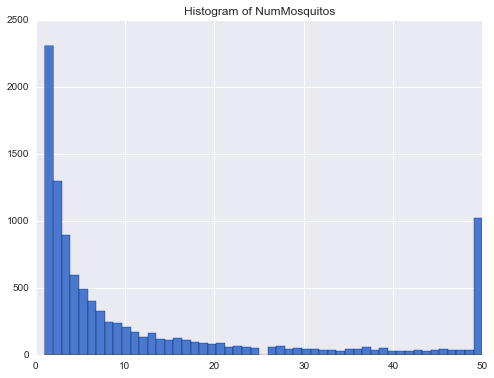

In [15]:
plt.hist(trap_training_data["NumMosquitos"], bins=51)
plt.title("Histogram of NumMosquitos")

The uptick at 50 is an artifact of how the data were collected. As described earlier, if more than 50 mosquitos were collected in a trap, that record got partitioned into multiple records.

Given that we won't have access to NumMosquitos in the test set *and* that there are so many days without trap records (this is the gap at x = 0), it's worth thinking about how we might fit NumMosquitos to a known distribution. If we ignore the spike at 50, the distribution *looks* exponential. However, a Poisson distribution, which is discrete-valued and deals with the distribution of counts in a certain unit of time, is more appropriate. In Poisson processes, we assume that individual events are independent. This is probably not a valid assumption in the case of mosquitos, but let's try a fit anyway. In an effort to smooth out the artifact at x = 50, we'll first group all events for a given trap and species together *by day*. This move will simultaneously serve to standardize the time unit. 

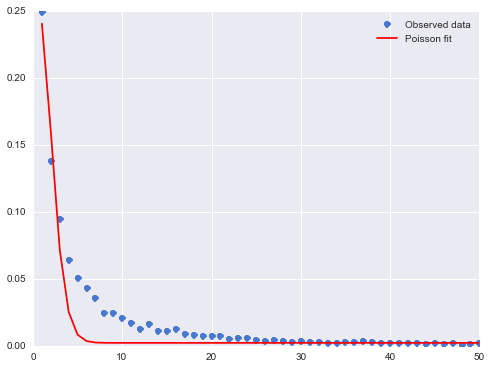

In [16]:
numMosquitosPoisson = trap_training_data.groupby(["Date", "Trap", "Species"]).sum()
tmp = numMosquitosPoisson["NumMosquitos"].value_counts().sort_index()
tmp /= tmp.sum()

from scipy.optimize import curve_fit
from scipy.misc import factorial

def poisson_fit(k, lam, a, c):
    return a * ((lam**k) * np.exp(-lam) / factorial(k)) + c

poiss_popt, poiss_pcov = curve_fit(poisson_fit, tmp.index.ravel(), tmp.values)

tmp.plot(style='o')
plt.plot(tmp.index, poisson_fit(tmp.index.ravel(), *poiss_popt), 'r-')
plt.xlim(0,50)
plt.legend(["Observed data", "Poisson fit"])

The fit looks pretty terrible for k > 3. Apparently, the real number of mosquitos decays too gradually for a Poisson to model it well. Perhaps this slow decay is the interdependence of events expressing itself, or perhaps — what might amount to the same thing — this is evidence of seasonality.

Below, we see that an exponential fit does a much better job. However, the "story" behind the exponential distribution, which is intended to model continuous-valued times between events, doesn't fit with our variable, so we should be wary of using it any model. Nonparametric methods may be safer.

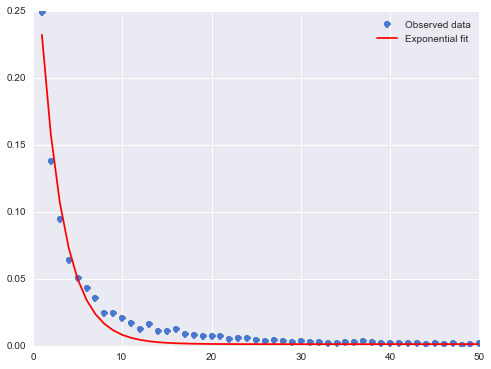

In [17]:
def expon_fit(x, lam, a, c):
    return a * (lam * np.exp(-lam*x)) + c

expon_popt, expon_pcov = curve_fit(expon_fit, tmp.index.ravel(), tmp.values)

tmp.plot(style='o')
plt.plot(tmp.index, expon_fit(tmp.index.ravel(), *expon_popt), 'r-')
plt.xlim(0,50)
plt.legend(["Observed data", "Exponential fit"])

#### Number of trap events by species

In [18]:
trap_training_data["Species"].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
dtype: int64

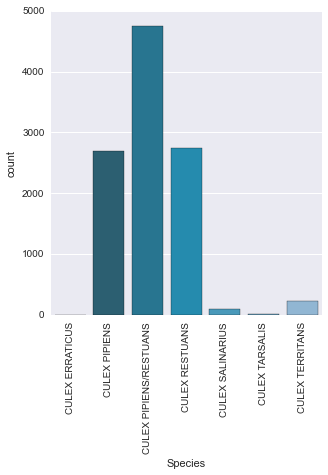

In [19]:
sns.factorplot("Species", data=trap_training_data, palette="PuBuGn_d")
plt.xticks(rotation=90)
plt.show()

There's a huge imbalance here. The last four species represent only ~1% of the species trapped, and *C. Erraticus* had only **one** occurrence in several years' worth of data!

#### Latitude and longitude

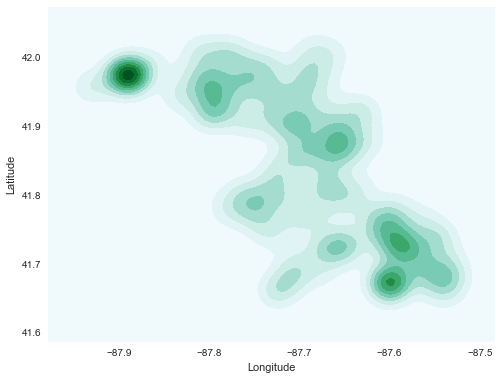

In [20]:
# 2D distribution of latitude & longitude 
sns.kdeplot(trap_training_data["Longitude"], 
            trap_training_data["Latitude"], shade=True)
plt.show()

We can see the specter of Chicago's geography (slightly rotated) in the 2D picture above. Trap events are not uniformly distributed across the city. A high concentration is at O'Hare Airport, in the top left corner, and there's also a high concentration of trap events on the South Side. 

Given this unusual distribution, latitude and longitude in their raw form may prove problematic — certainly for a linear model. Some sort of clustering as a preprocessing step might be a good idea. Using trap ids in favor of lat/lon is also an option, although the number of traps is on the order of 100 and creating dummy variables for each of these will take us into higher-dimensional territory.

#### Specific traps

What is the distribution of event counts across traps?

In [21]:
trap_training_data["Trap"].value_counts().describe()

count    136.000000
mean      77.250000
std       87.409276
min        2.000000
25%       23.000000
50%       64.000000
75%      104.250000
max      750.000000
dtype: float64

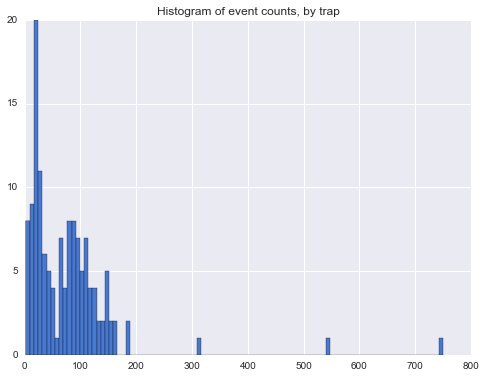

In [22]:
plt.hist(trap_training_data["Trap"].value_counts(), bins=100)
plt.title("Histogram of event counts, by trap")

This is far from a normal distribution. There are a few traps that got a large number of events, and there are many traps that got only ~30 events over the entire record keeping period. If we wish to use trap id as a feature, these low-event traps will inevitably have a lot of variance in the events attributed to them.

#### Summary of trap data

Our trap data looks appears to be quite unruly. We have two imbalanced classes (WnvPresent ~= 0.05), the records aren't regularly distributed across dates, our NumMosquitos variable doesn't conform well to a Poisson distribution and is difficult to interpret as an exponential, the species counts are imbalanced, and the event counts per trap follow no recognizable distribution.

Given that are we dealing with the complex field of epidemiology, we might have expected such unruliness. But it means that we will probably need to rely on rather flexible methods when it comes to building a model.

### Weather data

Next, let's explore variables of interest in our weather dataset.

In [23]:
weather_data["Date"] = pd.to_datetime(weather_data["Date"].values)

In [24]:
# Take a peek at the data
weather_data.columns

Index([u'Station', u'Date', u'Tmax', u'Tmin', u'Tavg', u'Depart', u'DewPoint',
       u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset', u'CodeSum',
       u'Depth', u'Water1', u'SnowFall', u'PrecipTotal', u'StnPressure',
       u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'],
      dtype='object')

In [25]:
weather_data.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,...,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,...,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9


In [26]:
# Get summary stats
weather_data.describe(include="all")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
count,2944.000000,2944,2944.000000,2944.000000,2933.000000,1472.000000,2944.000000,2940.000000,2933.000000,2933.000000,...,2944,1472,0,1472,2942,2940.000000,2935.000000,2944.000000,2944.000000,2941.000000
unique,NaN,1472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98,NaN,NaN,3,167,NaN,NaN,NaN,NaN,NaN
top,NaN,2014-08-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1609,NaN,NaN,1459,1577,NaN,NaN,NaN,NaN,NaN
first,NaN,2007-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2014-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.500000,NaN,76.166101,57.810462,67.240027,1.954484,53.457880,59.310884,3.407092,5.647119,...,NaN,0,NaN,NaN,NaN,29.284429,29.968129,6.960666,17.494905,8.580449
std,0.500085,NaN,11.461970,10.381939,10.545442,6.841110,10.675181,9.286742,5.953203,6.105087,...,NaN,0,NaN,NaN,NaN,0.158543,0.158597,3.587527,10.063609,3.147300
min,1.000000,NaN,41.000000,29.000000,36.000000,-17.000000,22.000000,32.000000,0.000000,0.000000,...,NaN,0,NaN,NaN,NaN,28.550000,29.230000,0.100000,1.000000,1.700000
25%,1.000000,NaN,69.000000,50.000000,60.000000,-3.000000,46.000000,53.000000,0.000000,0.000000,...,NaN,0,NaN,NaN,NaN,29.190000,29.870000,4.300000,7.000000,6.300000


The weather data set is more comprehensive in terms of its date ranges: 1472 unique dates across 7 years. It contains data for all the "gap" dates from the trap dataset, though it does not contain data for the colder months.

In [27]:
# Determine prevalence of missing data
weather_data.isnull().sum(axis=0) / len(weather_data)

Station        0.000000
Date           0.000000
Tmax           0.000000
Tmin           0.000000
Tavg           0.003736
Depart         0.500000
DewPoint       0.000000
WetBulb        0.001359
Heat           0.003736
Cool           0.003736
Sunrise        0.000000
Sunset         0.000000
CodeSum        0.000000
Depth          0.500000
Water1         1.000000
SnowFall       0.500000
PrecipTotal    0.000679
StnPressure    0.001359
SeaLevel       0.003057
ResultSpeed    0.000000
ResultDir      0.000000
AvgSpeed       0.001019
dtype: float64

We don't want to do too much imputation, so we should rule out several potential predictor variables, such as Depart (i.e. departure from normal temperature), Depth (i.e. depth of snow/ice on the ground), Waterl (the equivalent of snow depth, but for liquid water), and SnowFall. Many of these aren't pertinent during the warm months, of course.

As a first pass, the predictors that seem most of interest (and least in need of imputation) are:
* Tavg :: the average temperature for the day. We can impute any missing values using the surrounding days.
* DewPoint :: a measure of humidity, which factors into mosquito breeding habits.
* PrecipTotal :: also relevant for mosquito breeding. A few missing values, but we can impute.
* AvgSpeed :: average wind speed. Mosquito tend to breed more in still air. A few missing values here as well. 

We may also wish to consider Station, i.e. the station at which the weather data were recorded. However, there are only two stations, and they're located at Chicago's two main airports, neither of which is near the water. Also, both stations are equally well represented in the data: 

In [28]:
weather_data["Station"].value_counts()

1    1472
2    1472
dtype: int64

For the moment, let's not worry about differences between station. We will impute missing values for the other variables using the value from the day before. This will take care of the less than 1% of Tavg, AvgSpeed, and PrecipTotal values that are missing.

In [29]:
weather_data = weather_data.fillna(method="ffill")

#### Average temperature

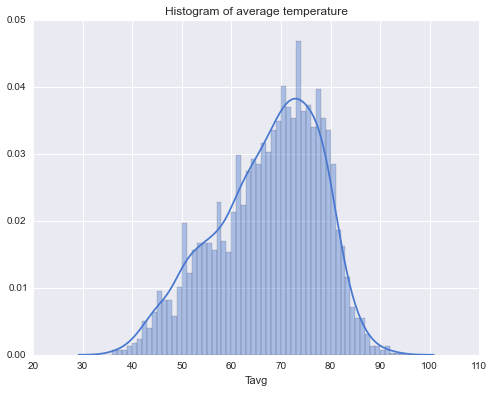

In [30]:
sns.distplot(weather_data["Tavg"], bins=np.arange(30,100))
plt.title("Histogram of average temperature")
plt.show()

Nothing too shocking here. The distribution seems well-behaved, with a slight negative skew. Are there major differences from year to year?

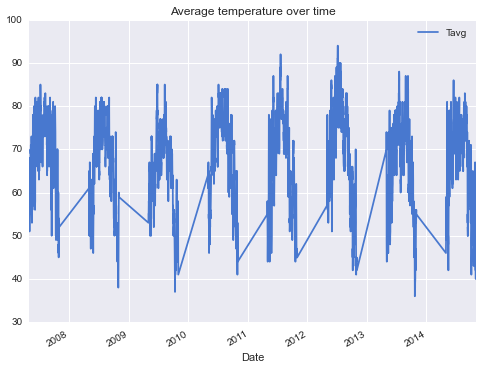

In [31]:
weather_data.plot("Date", "Tavg")
plt.title("Average temperature over time")

In [32]:
weatherByYear = weather_data.groupby(weather_data.Date.dt.year)
print "T avg: mean by year"
print weatherByYear["Tavg"].mean() 
print "\n" 
print "T avg: standard deviation by year"
print weatherByYear["Tavg"].std()

T avg: mean by year
2007    69.160326
2008    66.057065
2009    64.364130
2010    68.687500
2011    67.005435
2012    69.070652
2013    66.880435
2014    66.562500
Name: Tavg, dtype: float64


T avg: standard deviation by year
2007     8.973096
2008    10.065427
2009     9.764140
2010    10.238180
2011    11.461818
2012    11.946995
2013    10.768905
2014    10.051172
Name: Tavg, dtype: float64


On average, some years are a little warmer (2012), and some are a little cooler (2009), but the range is fairly narrow.

#### Dew point

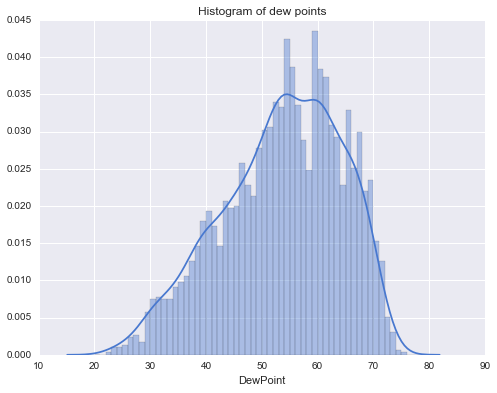

In [33]:
sns.distplot(weather_data["DewPoint"], bins=np.arange(20,80))
plt.title("Histogram of dew points")
plt.show()

Another normal-ish distribution, with some noise around the mean.

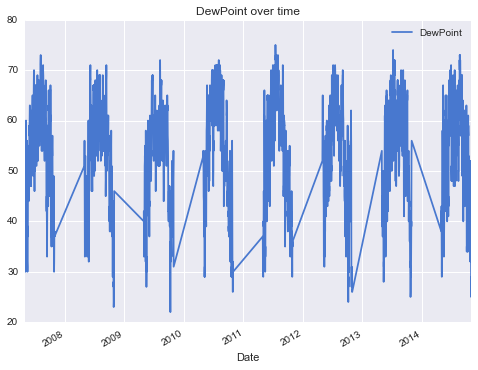

In [34]:
weather_data.plot("Date", "DewPoint")
plt.title("DewPoint over time")

In [35]:
print "Dew point: mean by year"
print weatherByYear["DewPoint"].mean()
print "\n" 
print "Dew point: standard deviation by year"
print weatherByYear["DewPoint"].std()

Dew point: mean by year
2007    54.236413
2008    52.733696
2009    51.904891
2010    54.785326
2011    54.396739
2012    52.475543
2013    53.983696
2014    53.146739
Name: DewPoint, dtype: float64


Dew point: standard deviation by year
2007    10.224781
2008    10.646909
2009     9.491954
2010    11.349302
2011    11.020426
2012    11.230770
2013    10.694151
2014    10.370793
Name: DewPoint, dtype: float64


#### Precipitation

In [36]:
weather_data["PrecipTotal"].describe()

count     2944
unique     167
top       0.00
freq      1579
Name: PrecipTotal, dtype: object

PrecipTotal is not coming across as a float, because "trace" precipitation is encoded as "T" in the original dataset. Let's fix that.

In [37]:
def trace_precip(s):
    try: 
        return float(s)
    except ValueError:
        s = 0.01
        return s

In [38]:
weather_data["PrecipTotal"] = weather_data["PrecipTotal"].apply(trace_precip)

In [39]:
# Confirm that it worked
weather_data["PrecipTotal"].describe()

count    2944.00000
mean        0.13232
std         0.39286
min         0.00000
25%         0.00000
50%         0.00000
75%         0.06000
max         6.86000
Name: PrecipTotal, dtype: float64

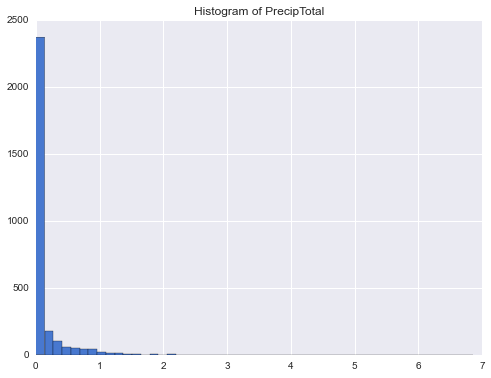

In [40]:
plt.hist(weather_data["PrecipTotal"], bins=50)
plt.title("Histogram of PrecipTotal")

This distribution looks exponential.

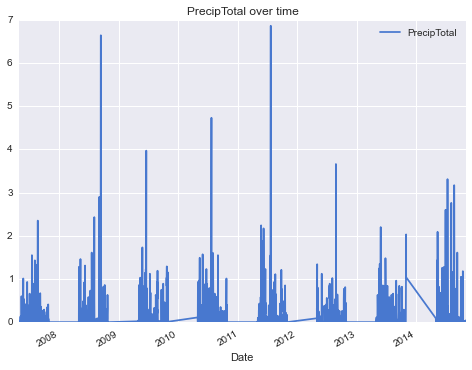

In [41]:
weather_data.plot("Date", "PrecipTotal")
plt.title("PrecipTotal over time")

In [42]:
print "Precipitation: mean by year"
print weatherByYear["PrecipTotal"].mean()
print "\n" 
print "Precipitation: standard deviation by year"
print weatherByYear["PrecipTotal"].std()

Precipitation: mean by year
2007    0.109701
2008    0.155516
2009    0.130897
2010    0.154158
2011    0.144783
2012    0.091603
2013    0.109973
2014    0.161929
Name: PrecipTotal, dtype: float64


Precipitation: standard deviation by year
2007    0.277907
2008    0.518269
2009    0.340600
2010    0.458110
2011    0.468197
2012    0.270247
2013    0.279729
2014    0.436722
Name: PrecipTotal, dtype: float64


The summers of 2007 and 2013 were relatively dry compared to, say, 2008 and 2011. However, rain is still a rare phenomenon — as indicated by the spike in the histogram at x = 0 — so even wet years are dominated by dry days. It will be interesting to see whether rain lines up with NumMosquitos or WNV.

#### Wind speed

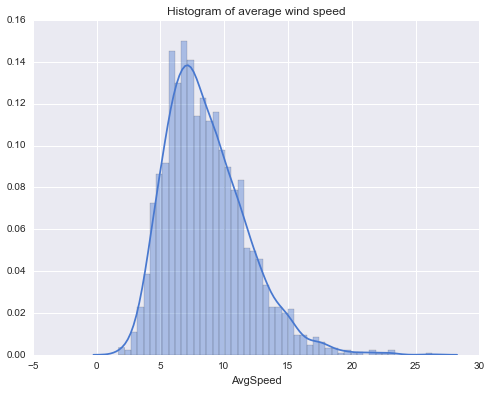

In [43]:
sns.distplot(weather_data["AvgSpeed"], bins=50)
plt.title("Histogram of average wind speed")
plt.show()

Fairly normal, with a slightly positive skew.

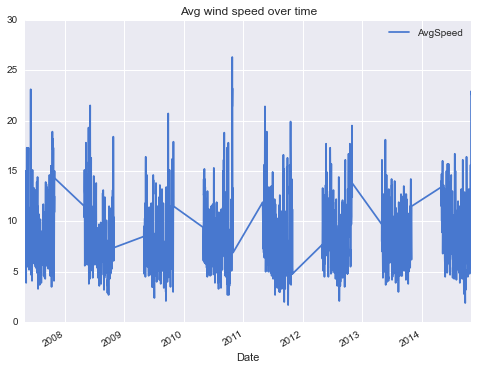

In [44]:
weather_data.plot("Date", "AvgSpeed")
plt.title("Avg wind speed over time")

In [45]:
print "Wind speed: mean by year"
print weatherByYear["AvgSpeed"].mean()
print "\n" 
print "Wind speed: standard deviation by year"
print weatherByYear["AvgSpeed"].std()

Wind speed: mean by year
2007    8.798098
2008    8.520924
2009    8.102174
2010    8.485870
2011    8.365217
2012    9.060870
2013    8.317935
2014    8.981522
Name: AvgSpeed, dtype: float64


Wind speed: standard deviation by year
2007    3.295513
2008    3.037095
2009    2.996864
2010    3.354539
2011    3.400919
2012    3.123566
2013    2.583200
2014    3.203980
Name: AvgSpeed, dtype: float64


From year to year, the average wind speed hardly changes.

#### Summary of weather data

After a quick inspection, most weather variables seem well-behaved and normally distributed, with the exception of PrecipTotal, whose distribution looks exponential. When we aggregrate statistics by year, we see years that are slightly warmer, more humid, or rainier, but these deltas in the mean are much smaller than the corresponding variances, and so if there are WNV outbreak years, we shouldn't expect the weather to have much explanatory value. Rather, we should expect the effects of weather on WNV to be at a smaller scale, from week to week, or month to month -- amplifying or attentuating epidemiological phenomena. 

### Spray data

Finally, we will take a look at the spray data.

In [46]:
spray_data["Date"] = pd.to_datetime(spray_data["Date"].values)

In [47]:
spray_data.describe(include="all")

,Date,Time,Latitude,Longitude
count,14835,14251,14835.000000,14835.000000
unique,10,8583,NaN,NaN
top,2013-08-15 00:00:00,7:44:32 PM,NaN,NaN
freq,2668,541,NaN,NaN
first,2011-08-29 00:00:00,NaN,NaN,NaN
last,2013-09-05 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,41.904828,-87.736690
std,NaN,NaN,0.104381,0.067292
min,NaN,NaN,41.713925,-88.096468
25%,NaN,NaN,41.785001,-87.794225


Two things jump out:
1. There are only 10 unique days across 6 years!
2. There is no information on quantity, spray type, etc. We get only date, time, and location information.

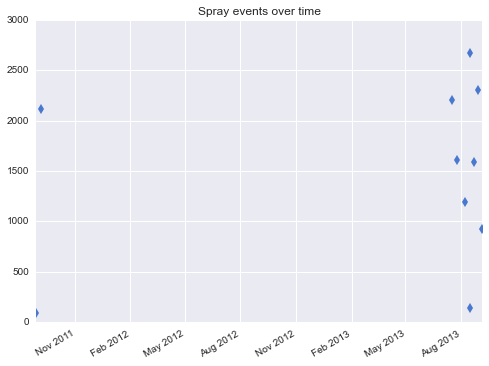

In [48]:
spray_data.Date.value_counts().plot(style='d')
plt.title("Spray events over time")

There was no spraying for the first four years of our trap data set. Then there was a short burst of spray events, after which spraying didn't pick up until the final year of the trap data. Moreover, we know from external sources that spraying wasn't deemed to be particularly effective. With all of this in mind, it's questionable how helpful spray data will be for our purposes.

More importantly, spray data isn't available in the test set, so we won't be able to incorporate it into our predictions. We will ignore it going forward.

---
## Exploratory data analysis: multiple variables

We now have a basic overview of our data. The trap data set has two unbalanced classes in the response variable, some unruly distributions in the predictors, multi-day gaps between trap events, and a few data collection quirks. The weather data set, by contrast, is comprehensive and well-behaved. Finally, the spray data aren't useful for prediction purposes.

Next, we want to start seeing how each potential predictor correlates with our response variable. 

A word of caution before proceeding, though. The ultimate test set contains records for the "gap" years. However, not all of the records in the test set are real — the trap testing set represent "possible" records, only some of which are real. As a result, we can't take any the presence of any test record as evidence for use in a model. For example, we cannot assume that an abundance of records on a particular date is real, and thus cannot update our beliefs of how probable an occurrence WNV is on that date. 

Additionally, even in these "possible" records, we will **not** be given the number of mosquitos, so our model cannot rely on this variable directly.

In [49]:
# Merge trap and weather data sets; pick only one station
trapWeather = pd.merge(trap_training_data, 
                       weather_data[weather_data["Station"] == 1], on = "Date")
trapWeather.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5


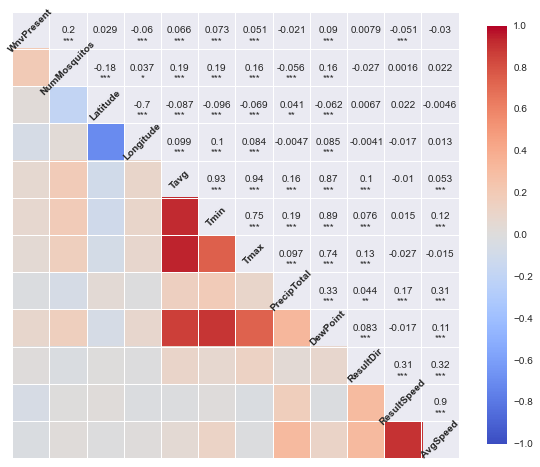

In [50]:
# Get pairwise correlations for a first-pass feature list
figsize(10, 10)

feats1 = ["WnvPresent", "NumMosquitos", "Latitude", "Longitude", 
          "Date", "Tavg", "Tmin", "Tmax", "PrecipTotal", 
          "DewPoint", "ResultDir", "ResultSpeed", "AvgSpeed"]

sns.corrplot(trapWeather[feats1])
plt.show()

WnvPresent, our response variable, has (very) weak correlations with a few variables:

* NumMosquitos
* DewPoint
* Tmin (minimum temperature)
* ResultSpeed (wind speed)

We know from external studies, though, that West Nile *is* correlated with humidity and temperature, so the weakness of these correlations may be a signal that WNV (and NumMosquitos) are resilient to small-scale fluctuations in weather or that there is a time lag between weather phenomena and how they affect mosquito populations. Or it may be that the way in which mosquitos end up getting spatially distributed across traps is obscuring the correlations. All of these ideas are worth exploring. 

Of course, any true correlations between our predictors and WNV is going to be attenuated by the imbalance in our dataset. We can sample the dataset so that WnvPresent = 0.5 and see how this affects our correlations. 

In [51]:
figsize(10, 10)
yes = trapWeather[trapWeather["WnvPresent"] == 1]
no = trapWeather[trapWeather["WnvPresent"] == 0]
no_sample = no.sample(n=len(yes))
balanced = pd.concat((yes, no_sample))
balanced["WnvPresent"].mean()

0.5

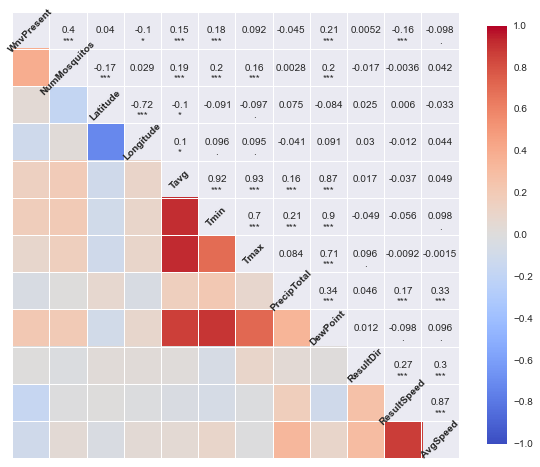

In [52]:
sns.corrplot(balanced[feats1])
plt.show()

As expected, the correlations with our possible predictors get stronger. They remain fairly weak, however.

Some observations about the correlation matrices:

* They lack information on date. To some extent, date is a blind alley, since our training and test sets come from alternating years, and so any date-based trends we observe in the former won't generalize to the latter. On the bright side, even if we can't capture epidemiological trends via date, much of the information relevant to mosquito abundances should be encoded in the weather data. With that in mind, joint time series of key variables are worth looking at in order get an intuition for how to extract features from the weather data.
* The matrices also lack information on categorical variables, notably species. This is certainly something to investigate.
* Latitude and longitude on their own show no real correlation with WNV. When considered jointly, they may, though it is still unlikely that they will exhibit any linear relationship to WNV. Using a categorical trap id variable or trying clustering, as mentioned earlier, may be shrewder bets here.

One further consideration: The correlation coefficients above are Pearson's r coefficients. Since the distribution of NumMosquitos wasn't necessarily parametric, we can see whether its Spearman coefficient is similar.

In [53]:
from scipy.stats import spearmanr
spearmanr(trapWeather["WnvPresent"], trapWeather["NumMosquitos"])[0]

0.20469632782239508

The Pearsonr coefficient for (NumMosquitos, WnvPresent) was 0.2, too, so the correlation holds up.

#### WNV and day

Is it a rare day when an WNV event is recorded, or are there cases recorded every day? Let's aggregate the records by day and take a look.

In [54]:
trapWeatherByDay = trapWeather.groupby(trapWeather["Date"])

In [55]:
wnvByDay = trapWeatherByDay["WnvPresent"]
wnvByDay.sum().describe()

count    95.000000
mean      5.800000
std       9.694921
min       0.000000
25%       0.000000
50%       1.000000
75%       7.000000
max      38.000000
Name: WnvPresent, dtype: float64

The median number of WNV events per day is one. This means that WNV is a lingering phenomenon. Unfortunately for us, if our model doesn't account for the incidents of WNV on these quiet days, its recall score will be bounded above at $1 - ((95 * 0.5) \div (5.8 * 95))= 0.91$. A score this low would be a bad thing if we're trying to predict a potentially deadly virus.

We can also look at a visual of the distribution.

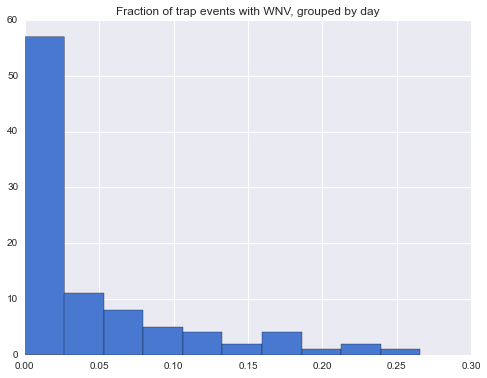

In [56]:
figsize(8,6)
plt.hist(wnvByDay.mean())
plt.title("Fraction of trap events with WNV, grouped by day")

There are more extreme days, but even on these days that might be considered "outbreaks," only about 25% of trap events will have mosquitos with WNV. In other words, it's still mostly haystack and not too much needle.

We should keep in mind that, in the above histogram and elsewhere, we are always talking about the fraction of **trap events** with WNV, not the fraction of **mosquitos** with WNV. It takes only one mosquito with WNV to make WnvPresent flip to 1. In other words, days that seem "WNV-heavy" might merely be explainable as "mosquito-heavy." Were that the case, we would expect WNV incidence to increase as the number of mosquitos per trap rises. Let's see whether this expectation holds.

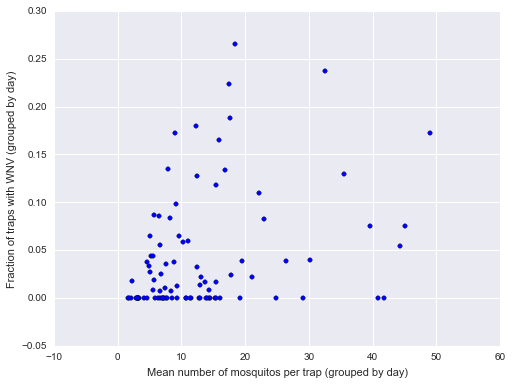

In [57]:
wnvNumByDay = trapWeatherByDay[["NumMosquitos", "WnvPresent"]]

plt.scatter(wnvNumByDay.mean()["NumMosquitos"], wnvNumByDay.mean()["WnvPresent"])
plt.xlabel("Mean number of mosquitos per trap (grouped by day)")
plt.ylabel("Fraction of traps with WNV (grouped by day)")

The trend seems to be there: More mosquitos per trap means a higher incidence of WNV. If we average **across** days (below) rather than **within** days, the trend stands out even more.

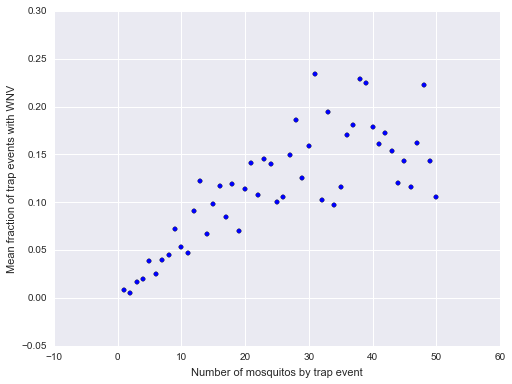

In [58]:
NumMosquitosMeanWnv = trapWeather["WnvPresent"].groupby(trapWeather["NumMosquitos"]).mean()

plt.scatter(NumMosquitosMeanWnv.index, NumMosquitosMeanWnv)
plt.xlabel("Number of mosquitos by trap event")
plt.ylabel("Mean fraction of trap events with WNV")

And yet, to reiterate, we don't have access to NumMosquitos in our testing set, so if we want to make use of this trend, we will have to infer the number of mosquitos indirectly.

Another question we can ask is: Are these extremes in WNV incidents spread out uniformly, or are there periods when they're more common?

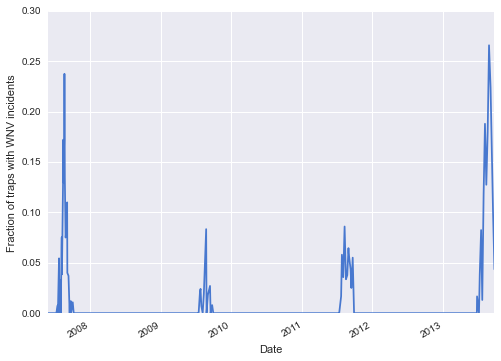

In [59]:
plt.xlabel("Date")
plt.ylabel("Fraction of traps with WNV incidents")
wnvByDay.mean().plot()

Features that we can see here:
* Each year appears to have a spike in the middle of the summer. 
* Two years definitely seem like "outbreak years," at least relative to the others. 

We would like our predictive model to take advantage of these outbreak trends, but as mentioned above, our testing data contains only "possible" records and they're for different years than the years in the training set, so we're out of luck! The hope is that conditions *conducive* to outbreaks can be inferred through weather data — the weather data, thankfully, is "real" and not "possible" — but failing any actual direct epidemiological data, we may have to settle for slightly better posteriors. 

On another note, if we were tempted to hold onto our spray data, we observe that spraying happened in 2011 and in 2013 but not in the other years. So indeed, the spraying efforts don't seem to have had much effect.

#### WNV trends vis-a-vis other trends 

Next question: Are WNV spikes aligned with NumMosquitos spikes? And how do each line up with the behavior of the weather variables that are correlated with WNV? 

In [60]:
numByDay = trapWeatherByDay["NumMosquitos"]
TminByDay = trapWeatherByDay["Tmin"]
DewPtByDay = trapWeatherByDay["DewPoint"]
ResultSpeedByDay = trapWeatherByDay["ResultSpeed"]

In [61]:
# Boundaries for the plots below; ugly but saves us some datetime work
year_dates = ["2007-06-07", "2007-10-15", "2009-05-29", "2009-09-29",
     "2011-05-29", "2011-09-29", "2013-05-29", "2013-09-29"]

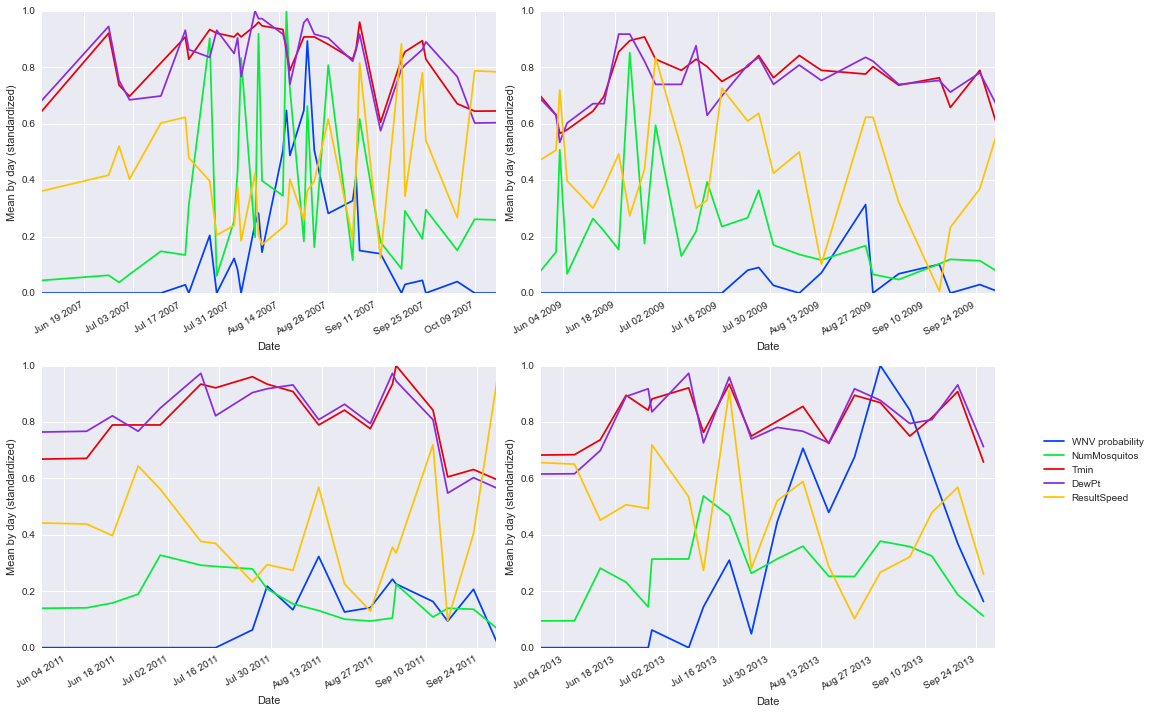

In [62]:
figsize(14,10)
sns.set_palette("bright")

f, axes = plt.subplots(2, 2)
i = 0

for ax in axes.ravel():
    for k in [wnvByDay, numByDay, TminByDay, DewPtByDay, ResultSpeedByDay]:
        (k.mean()/k.mean().max()).plot(sharex=False, ax=ax, 
                                       xlim=(year_dates[i], year_dates[i+1]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Mean by day (standardized)")
    i += 2

plt.legend(["WNV probability", "NumMosquitos", "Tmin", "DewPt", "ResultSpeed"], loc=(1.1,0.5))
plt.tight_layout()
plt.show()

Several interesting things to note here:

* Each year, the global maximum for NumMosquitos tends to *precede* the global maximum for WNV, sometimes by as much as two months, but local maxima do seem to line up. In other words, significant mosquito abundances in a given year tend to precede significant rises in WNV incidents, but when there is a spike in mosquito abundances, there tends to be an accompanying spike in WNV. 
* The **magnitude** of the spikes in NumMosquitos and WNV don't quite line up from year to year. Just because it's a banner year for WNV doesn't mean NumMosquitos is at a relative high; we see this in 2013. Conversely, just because there's a mosquito abundance one year doesn't mean it's a WNV outbreak year; we see this in 2009. A simple explanation for these mismatches is that there is an epidemiology for West Nile over and above mosquitos abundances and weather phenomena.
* Tmin and DewPoint are reasonably well coordinated with NumMosquitos from year to year. With this coordination in mind, and considering the lag between NumMosquitos and WNV, we might try introducing a time lag or a rolling mean. The literature — for example, [this paper](http://www.parasitesandvectors.com/content/6/1/129) — offers some guidance on how to initialize time lags for different weather variables. This approach might allow us to relate weather to WNV without using NumMosquitos as an intermediary.
* ResultSpeed, which describes wind speed, exhibits curious behavior. In 2011 and 2013, its local minima are often aligned with WNV spikes, despite the fact that its global minimum in 2009 and 2011 doesn't correspond to any WNV activity *and* the fact that its correlation with WnvPresent, as we saw above, is *negative*. We can concoct a story to explain this — mosquitos can't breed unless the wind speed is low, but once they have bred, a higher wind speed can help spread WNV geographically — but this story might be a case of overzealous pattern seeking. At the same time, it suggests that we try to pair a set of time-lagged weather features with a set of short-timescale weather features when we are building our model.

#### WNV by species

We already know that some species are far more prevalent in the trap data. What does species tell us about WNV?

In [63]:
trapWeatherBySpecies = trapWeather.groupby("Species").mean()
trapWeatherBySpecies["WnvPresent"]

Species
CULEX ERRATICUS           0.000000
CULEX PIPIENS             0.088922
CULEX PIPIENS/RESTUANS    0.055135
CULEX RESTUANS            0.017883
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
Name: WnvPresent, dtype: float64

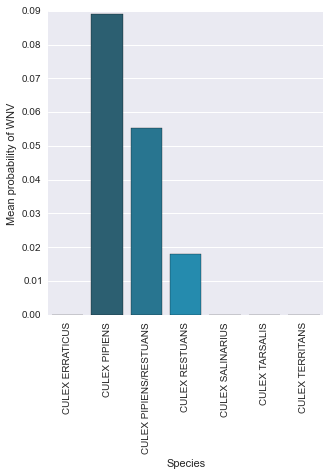

In [64]:
wnvBySpecies = trapWeatherBySpecies["WnvPresent"]
wnvBySpecies = wnvBySpecies.reset_index()
sns.factorplot("Species", "WnvPresent", data=wnvBySpecies, kind="bar", palette="PuBuGn_d")
plt.ylabel("Mean probability of WNV")
plt.xticks(rotation=90)
plt.show()

So there are really only three species that carry WNV. This variable will add more information to our model.

Next, a question about temporal trends: Does the lag between NumMosquitos and WNV that we observed above (across all species) hold on a per-species level?

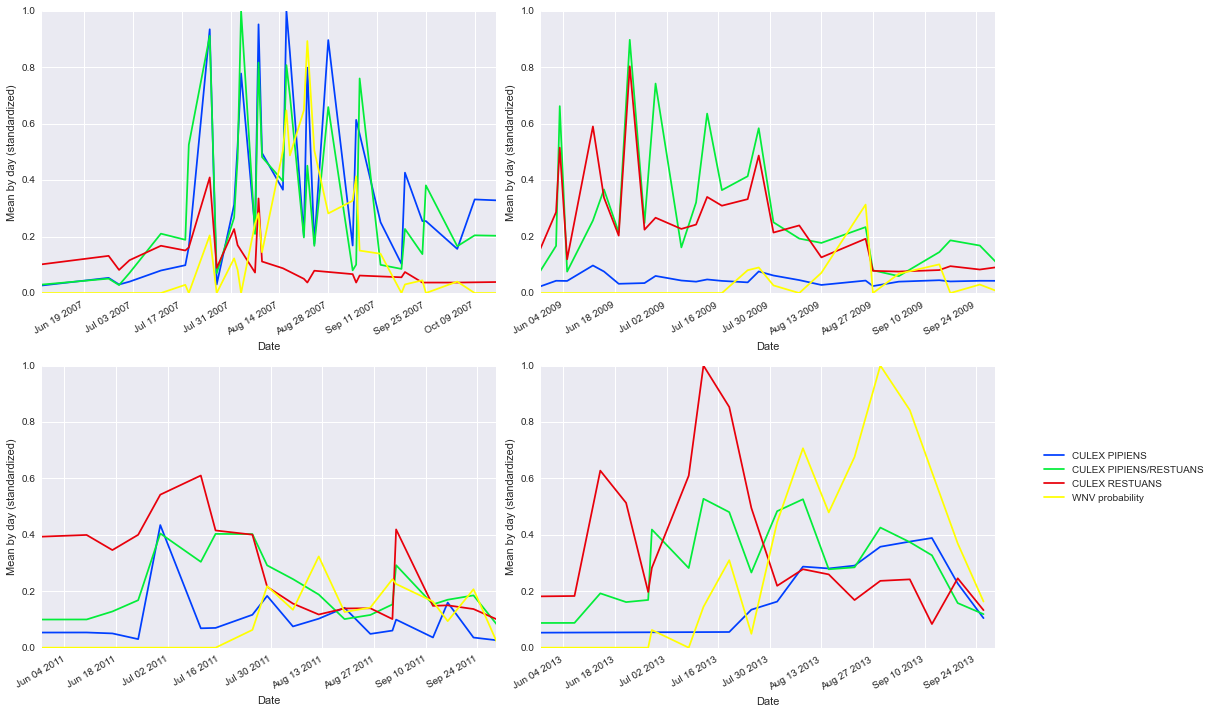

In [65]:
figsize(14,10)
sns.set_palette("bright")

f, axes = plt.subplots(2, 2)
spec = ["CULEX PIPIENS", "CULEX PIPIENS/RESTUANS", "CULEX RESTUANS"]
k = 0

for ax in axes.flat:
    for i in spec:
        f = trapWeather[trapWeather["Species"] == i].groupby("Date")
        g = f["NumMosquitos"]
        (g.mean()/g.mean().max()).plot(sharex=False, ax=ax, 
                                       xlim=(year_dates[k], year_dates[k+1]))
    ax.plot((wnvByDay.mean()/wnvByDay.mean().max()).index, 
            (wnvByDay.mean()/wnvByDay.mean().max()), color="yellow")
    ax.set_xlabel("Date")
    ax.set_ylabel("Mean by day (standardized)")
    k += 2

plt.legend(["CULEX PIPIENS", "CULEX PIPIENS/RESTUANS", 
            "CULEX RESTUANS", "WNV probability"], loc=(1.1,0.5))
plt.tight_layout()
plt.show()

*C. Pipiens*, the species with the highest rate of WNV, seems slightly better aligned with WNV outbreaks than *C. Restuans* and the mixture group do, but the plots are pretty noisy.

#### WNV by trap

We've seen that certain traps show up in the records more. Some related questions: 

* Do traps with many records have more mosquitos on average? 
* Do they have a higher incidence of WNV?

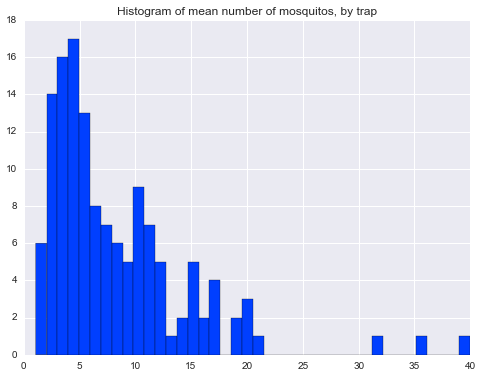

In [66]:
figsize(8, 6)

trapWeatherByTrap = trapWeather.groupby("Trap")
plt.hist(trapWeatherByTrap["NumMosquitos"].mean(), bins=40)
plt.title("Histogram of mean number of mosquitos, by trap")

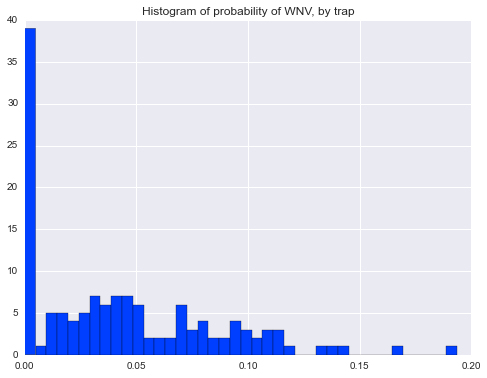

In [67]:
plt.hist(trapWeatherByTrap["WnvPresent"].mean(), bins=40)
plt.title("Histogram of probability of WNV, by trap")

So some traps are getting a lot more mosquitos on average, and some traps have a much higher incidence of WNV. Are these traps one and the same?

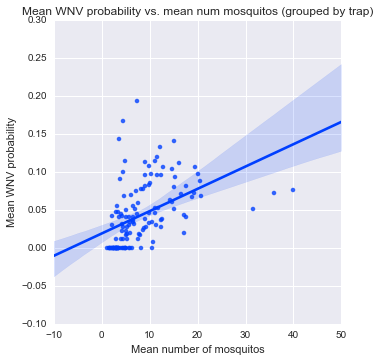

In [68]:
figsize(10,10)

WnvNumByTrap = trapWeatherByTrap[["WnvPresent", "NumMosquitos"]]

sns.lmplot("NumMosquitos", "WnvPresent", data=WnvNumByTrap.mean())
plt.title("Mean WNV probability vs. mean num mosquitos (grouped by trap)")
plt.xlabel("Mean number of mosquitos")
plt.ylabel("Mean WNV probability")
plt.show()

Not exactly. The traps that are collecting the most mosquitos per record don't have a particularly high WNV probability. And the traps that do have the highest WNV probabilities tend not to trap too many mosquitos per record. The general trend that we observed earlier — number of mosquitos is correlated with WNV probability — is still present, but there are a handful of traps bucking that trend. 

Why is that? Are these abberations due to sample size? Let's look at the same plot, only this time we'll encode **sums** too.

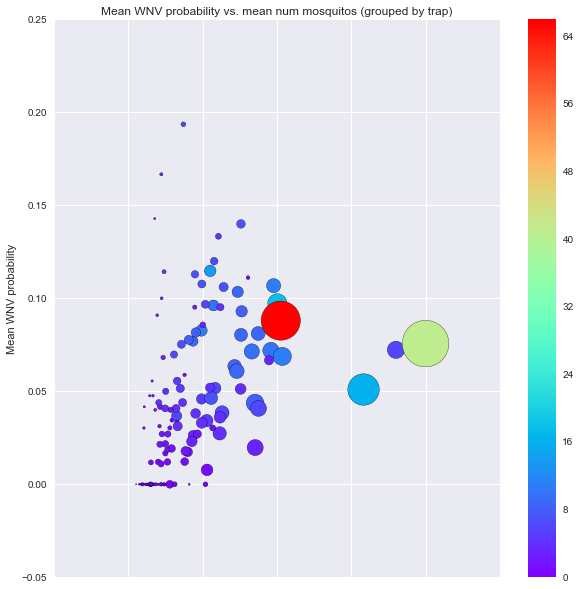

In [69]:
figsize(10,10)

WnvNumByTrap = trapWeatherByTrap[["WnvPresent", "NumMosquitos"]]
WnvNumByTrapMean = WnvNumByTrap.mean()
WnvNumByTrapMean.columns = ["WnvMean", "NumMean"]
WnvNumByTrapSum = WnvNumByTrap.sum()
WnvNumByTrapSum.columns = ["WnvSum", "NumSum"]
WnvNumByTrapAgg = pd.merge(WnvNumByTrapMean, WnvNumByTrapSum, 
                           left_index=True, right_index=True)

WnvNumByTrapAgg.plot(kind='scatter', x="NumMean", y="WnvMean", 
                     s=WnvNumByTrapAgg["NumSum"]*0.1,
                     c=(WnvNumByTrapAgg["WnvSum"]),
                    colormap='rainbow')

plt.title("Mean WNV probability vs. mean num mosquitos (grouped by trap)")
plt.xlabel("Mean number of mosquitos")
plt.ylabel("Mean WNV probability")
plt.show()

In the above plot, each bubble represent a single trap. 

* The **size** of a bubble corresponds to the **total number of mosquitos** that were caught in that trap across all dates. 
* The **color** corresponds to the **total number of WNV incidents** for that trap.

Thus, traps that seemed like they were bucking the general trend are merely artifacts of a small sample size. Since we want to develop a highly sensitive model, we can't ignore these traps altogether, but we can find a way to weight them appropriately.

#### WNV by latitude & longitude

Let's take a look at how WNV and NumMosquitos are distributed spatially compared to trap events generally. (We are going to treat latitude and longitude as rectilinear coordinates, not spherical coordinates, given how small the Chicagoland area is relative to the Earth.)

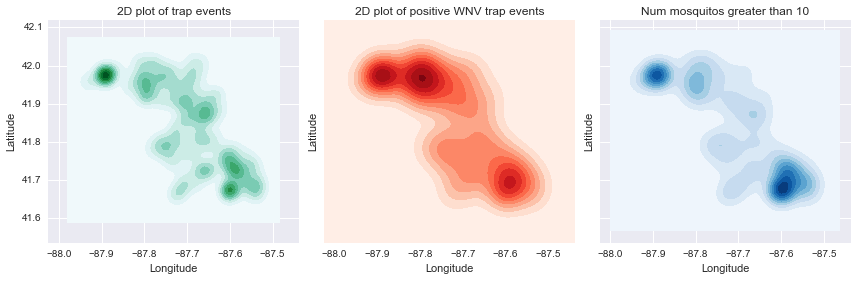

In [70]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

wnvPositive = trapWeather[trapWeather["WnvPresent"] == 1]
numMosquitosHigh = trapWeather[trapWeather["NumMosquitos"] >= 10]

sns.kdeplot(trapWeather["Longitude"], trapWeather["Latitude"], ax=ax1, shade=True)
sns.kdeplot(wnvPositive["Longitude"], wnvPositive["Latitude"], cmap="Reds", shade=True, ax=ax2)
sns.kdeplot(numMosquitosHigh["Longitude"], numMosquitosHigh["Latitude"], cmap="Blues", shade=True, ax=ax3)

ax1.set_title("2D plot of trap events")
ax2.set_title("2D plot of positive WNV trap events")
ax3.set_title("Num mosquitos greater than 10")

plt.tight_layout()
plt.show()

The plots above give credence to some of our findings thus far. Trap event abundances follow a different (but not altogether unrelated) spatial distribution relative to WNV events; WNV events, in turn, have a similar (but not altogether identical) distribution relative to NumMosquitos abundances.

To get more out of spatial variables — and not be forced to rely on either 100+ trap variables or nonparametric latitude and longitude marginals — we will likely need to do some clustering. This takes us to our next section.

----
## Feature transformation and extraction

Where do we stand at this point? We have a few variables that seem like they may help us predict the presence of WNV. These include the trap, the species of the mosquitos, certain weather variables (such as temperature, dew point, and wind speed), and the number of mosquitos — a variable that, again, we will not get in our training set.

Even so, the predictive power of these variables doesn't amount to much, as suggested by the plot below (which utilizes seaborn's native logistic regression model). Our top two candidate predictors don't lead us to even a single instance where the probability of finding WNV approaches 0.5.

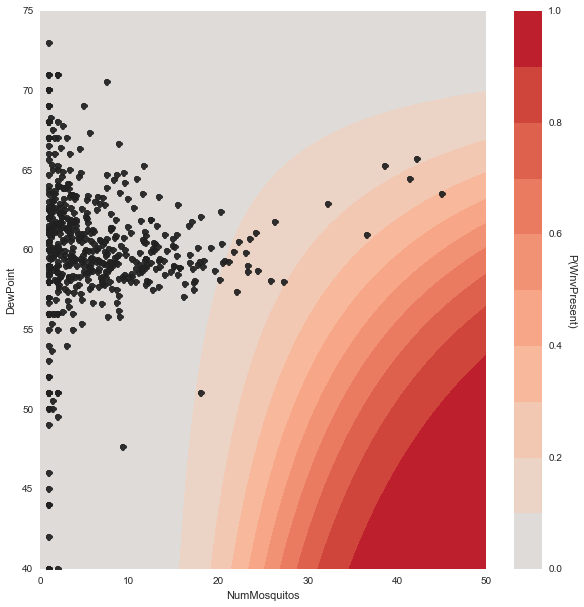

In [71]:
tmp2 = trapWeather.groupby(["Trap", "Species"]).mean()
sns.interactplot("NumMosquitos", "DewPoint", "WnvPresent", tmp2, 
                 filled=True, levels=10, cmap="coolwarm", logistic=True);

This suggests we try to transform existing features or create new features. A number of possibilities have already been discussed. Here is a more comprehensive list, which includes some new ideas.

* **Weather-based features**
    * Time-lagged weather features: We have seen evidence that weather trends precede WNV trends, even as local minima are aligned. One way to align the global trends is to do a simple time shift. However, if we're trying to get at large-scale trends and smooth out small-scale fluctuations, a rolling mean might work better.
    * NumMosquitos proxy: NumMosquitos and our leading weather predictors were very much aligned. We could attempt to create a NumMosquitos proxy feature in order to get around the absence of this variable in our test set. Then again, this inference step would likely be error-prone, and if we can find better direct correlations between WnvPresent and weather variables, we should favor that option.
    * Daylight time: Though we haven't explored this idea yet, daylight time — i.e. sunset time minus sunrise time — is deemed a good predictor of mosquito abundance by experts. Along with other weather data, this proxy feature could be fed into any time lag transformation that we do.
* **Trap-based features** 
    * There are 136 traps, so to create dummy variables for each might tax any model we try to implement, particularly a nearest neighbor model. Instead, we could considering encoding probabilities for each trap as features, possibly conditioning on weather variables.
    * Another approach is to cluster by trap and see whether they differ significantly in their WNV probabilities, then use the clusters as features (where the number of clusters will be much less than 136).
* **Species** 
    * We simply need to encode species via a set of dummy variables. There are only 7 species, so this shouldn't tax our model too much.

### Weather: additional features

A rolling mean of weather variables accomplishes two goals. It encodes information about weather trends leading up to the present moment, and it smoothes out small-timescale fluctuations. We'll do a simple moving average rather than an exponentially weighted one so that more recent dates aren't given too much weight. Leveraging the results from [this paper](http://www.parasitesandvectors.com/content/6/1/129) — see, in particular [this figure](http://www.parasitesandvectors.com/content/6/1/129/figure/F3) — we'll begin by using the following window values for the moving average:

* Temperature: 18 days
* Wind speed: 23 days
* Daylight time: 39 days
* Precipitation: 76 days
* Humidity: 106 days

We can tinker with different window sizes later to see if we get better results.

First, though, we need to compute daylight time. Recall that the trap data has only 95 unique dates over a four-year period, and so we dropped a lot of weather data when we merged our trap and weather dataframes. Let's return to the original weather dataset to compute daylight and, after that, our rolling means. Then we can merge these new variables to a brand-new dataframe.

In [72]:
# Sunset and sunrise are encoded as, e.g., 0425; let's transform that
def encode_time(s): 
    return float(s[:-2]) + float(s[-2:])/60

In [73]:
# Grab only Station 1 data
weather_1 = weather_data[weather_data["Station"] == 1]

In [74]:
# Verbose code to deal with pandas setting with copy snafus
sunset = weather_1["Sunset"].apply(lambda x: x.lstrip("0")).apply(encode_time)
weather_1.loc[:, "Sunset_float"] = np.array(sunset)

sunrise = weather_1["Sunrise"].apply(lambda x: x.lstrip("0")).apply(encode_time)
weather_1.loc[:, "Sunrise_float"] = np.array(sunrise)
# don't worry... the warning is just a warning

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [75]:
weather_1.loc[:, "Daylight"] = weather_1["Sunset_float"] - weather_1["Sunrise_float"]

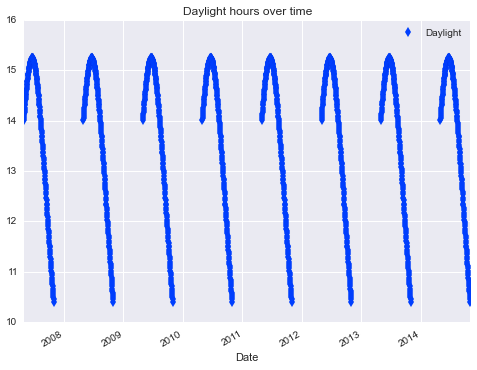

In [76]:
figsize(8,6)
weather_1.plot("Date", "Daylight", style='d')
plt.title("Daylight hours over time")

That looks about right. The gaps are due to the fact that the weather data set doesn't contain records for the cold months. It would take some acrobatics to get around these discontinuities when computing our rolling mean. As a first pass, we won't worry about it.

In [77]:
def rolling_mean(df, col, window):
    movingcol = col + "Moving"
    df.loc[:, movingcol] = pd.rolling_mean(df[col], window)
    df.loc[:, movingcol] = df[movingcol].fillna(method="bfill")

In [78]:
rolling_mean(weather_1, "Tmin", 18)
rolling_mean(weather_1, "ResultSpeed", 23)
rolling_mean(weather_1, "Daylight", 39)
rolling_mean(weather_1, "PrecipTotal", 76)
rolling_mean(weather_1, "DewPoint", 106)

In [79]:
# Merge this df with the original trap data and put it in a new df
trapWeatherMoving = pd.merge(trap_training_data, weather_1)

Next, we want to see if the correlations between WnvPresent and these rolling means are any stronger than they were with the original variables.

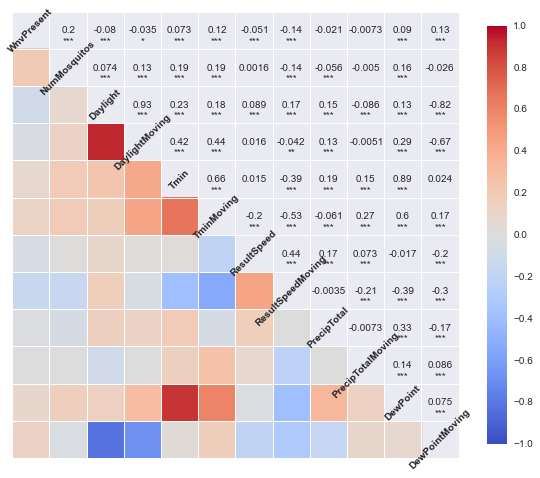

In [80]:
figsize(10,10)

sns.corrplot(trapWeatherMoving[["WnvPresent", "NumMosquitos", "Daylight", 
                                "DaylightMoving", "Tmin", "TminMoving", 
                                "ResultSpeed", "ResultSpeedMoving", "PrecipTotal", 
                                "PrecipTotalMoving", "DewPoint", "DewPointMoving"]])
plt.show()

For the most part, the weather features we were considering before — Tmin, ResultSpeed, and DewPoint — all show a stronger correlation with WnvPresent than their single-day counterparts do. PrecipTotal is the exception. Daylight, which the authors of the paper said showed the strongest correlation with mosquito abundance, is less correlated with WnvPrsent than many of our other weather variables are. What's more, the correlation is **negative**. 

The correlations with NumMosquitos are more mixed. The moving versions of daylight and wind speed do better than their single-day counterparts; the moving versions of precipitation and dew point do worse.

These relatively poor correlations may be due to the details of how the correlations or rolling means were computed. We may want to try different time windows. A more likely source of error is how our two main variables of interest,  NumMosquitos and WnvPresent, are encoded; the former is on a per-trap basis and will be subject to the noise of how mosquitos distribute themselves spatially, and the latter is binary rather than a pure ratio of infected mosquitos.

Before we try out different windows, let's see how the correlation matrix looks if we smooth out some daily noise by taking the mean of trap events per day. (A sum might be more useful for WnvPresent, but it would be meaningless to sum weather variables.)

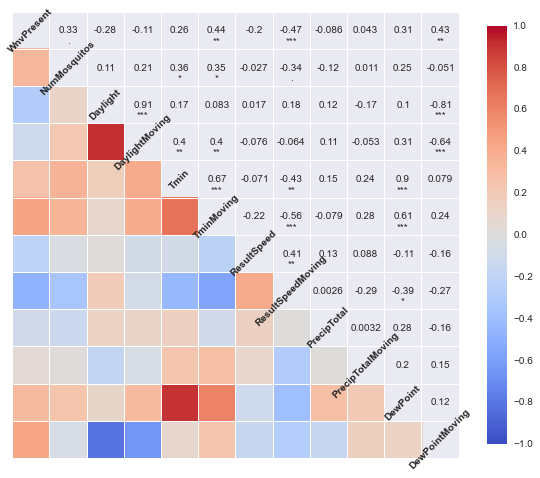

In [81]:
dayMean = trapWeatherMoving.groupby(trapWeatherMoving["Date"]).mean()

figsize(10,10)

sns.corrplot(dayMean[["WnvPresent", "NumMosquitos", "Daylight", "DaylightMoving",
                         "Tmin", "TminMoving", "ResultSpeed", "ResultSpeedMoving", 
                        "PrecipTotal", "PrecipTotalMoving", "DewPoint", "DewPointMoving"]])
plt.show()

As we might expect, the correlations get better. 

Curiously, daylight is still anti-correlated with WNV. We can imagine a story that explains this phenomenon. Perhaps more daylight entails more mosquitos, and more mosquitos entails more WNV, but the growth of NumMosquitos outpaces the growth of WNV, and so WNV actually gets more diffuse across the mosquito population. Thus, the **means** — which are what we compute in the above correlation matrix — are anti-correlated.

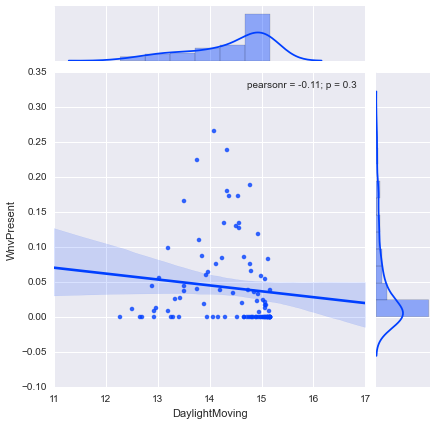

In [82]:
sns.jointplot("DaylightMoving", "WnvPresent", data=dayMean, kind="reg")

This is a plausible enough story, but if it were true, why do all the other weather variables show heightened correlations in the same direction when we take a rolling mean? Tmin gets more positively correlated with WNV, as does DewPoint, and ResultSpeed gets more negatively correlated.

Did our rolling mean get miscomputed?

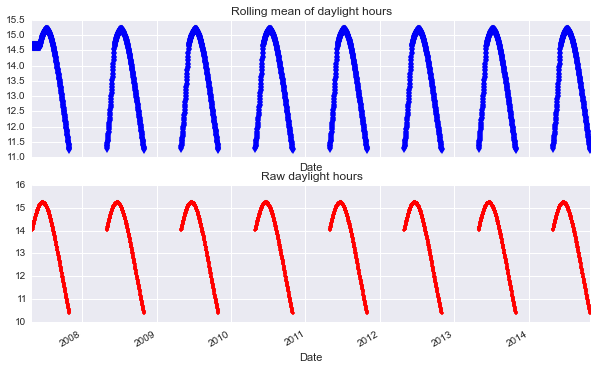

In [83]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
weather_1.plot("Date", "DaylightMoving", ax=ax1, style='bd', legend=False)
weather_1.plot("Date", "Daylight", ax=ax2, style='r.', legend=False)
ax1.set_title("Rolling mean of daylight hours")
ax2.set_title("Raw daylight hours")

No, this seems correct.

Regardless, for most weather variables, a rolling mean gives us a stronger correlation with WNV incidents than the raw variables do. When we take the mean number of WNV incidents per day, and even more so when we take the sum, those correlations improve dramatically. In our original disaggregated view, the specifics of how mosquitos are distributed spatially across traps — and even across trap events for the same trap! — introduces a fair amount of (hopefully Gaussian) noise to the problem and weakens our correlations.

Our next tactic is to tune the window size for our rolling means. Since we won't have NumMosquitos in our training set, let's optimize for the correlation with the response variable, WnvPresent, rather than keep harping on NumMosquitos. Let's roll our own parameter space search function to make this happen.

In [84]:
def rolling_search(df1=weather_1, df2=trap_training_data, win_start=14, win_stop=60, stride=2, col=None):
    for i in range(win_start, win_stop+1)[::stride]:
        rolling_mean(df1, col, i)
        df3 = pd.merge(df2, df1)
        movingcol = col + "Moving"
        cc = np.corrcoef(df3[movingcol].values, df3["WnvPresent"].values)[1][0]
        print movingcol, "| window :", i, "--> corr coeff =", cc

In [85]:
rolling_search(col="Tmin", win_start=10, win_stop=90, stride=2)

TminMoving | window : 10 --> corr coeff = 0.0913084963147
TminMoving | window : 12 --> corr coeff = 0.0991652268176
TminMoving | window : 14 --> corr coeff = 0.107117400115
TminMoving | window : 16 --> corr coeff = 0.112806450068
TminMoving | window : 18 --> corr coeff = 0.120027532067
TminMoving | window : 20 --> corr coeff = 0.123871654292
TminMoving | window : 22 --> corr coeff = 0.130556210852
TminMoving | window : 24 --> corr coeff = 0.132067216138
TminMoving | window : 26 --> corr coeff = 0.131472207763
TminMoving | window : 28 --> corr coeff = 0.131608833208
TminMoving | window : 30 --> corr coeff = 0.134213884652
TminMoving | window : 32 --> corr coeff = 0.137341822179
TminMoving | window : 34 --> corr coeff = 0.137124574168
TminMoving | window : 36 --> corr coeff = 0.138015309221
TminMoving | window : 38 --> corr coeff = 0.140756099944
TminMoving | window : 40 --> corr coeff = 0.141210432535
TminMoving | window : 42 --> corr coeff = 0.140886145454
TminMoving | window : 44 --> 

In [86]:
rolling_search(col="ResultSpeed", win_start=10, win_stop=50)

ResultSpeedMoving | window : 10 --> corr coeff = -0.0929699436659
ResultSpeedMoving | window : 12 --> corr coeff = -0.103361930223
ResultSpeedMoving | window : 14 --> corr coeff = -0.110808787943
ResultSpeedMoving | window : 16 --> corr coeff = -0.130315389589
ResultSpeedMoving | window : 18 --> corr coeff = -0.125646930387
ResultSpeedMoving | window : 20 --> corr coeff = -0.131153465232
ResultSpeedMoving | window : 22 --> corr coeff = -0.13543328099
ResultSpeedMoving | window : 24 --> corr coeff = -0.142251943245
ResultSpeedMoving | window : 26 --> corr coeff = -0.148332780513
ResultSpeedMoving | window : 28 --> corr coeff = -0.149104823657
ResultSpeedMoving | window : 30 --> corr coeff = -0.152434725045
ResultSpeedMoving | window : 32 --> corr coeff = -0.156049730643
ResultSpeedMoving | window : 34 --> corr coeff = -0.153648599105
ResultSpeedMoving | window : 36 --> corr coeff = -0.15047444064
ResultSpeedMoving | window : 38 --> corr coeff = -0.15091058031
ResultSpeedMoving | window 

In [87]:
rolling_search(col="Daylight", win_start=10, win_stop=100, stride=5)

DaylightMoving | window : 10 --> corr coeff = -0.0735442893802
DaylightMoving | window : 15 --> corr coeff = -0.069398354227
DaylightMoving | window : 20 --> corr coeff = -0.0645233586088
DaylightMoving | window : 25 --> corr coeff = -0.0589676839917
DaylightMoving | window : 30 --> corr coeff = -0.0522044239377
DaylightMoving | window : 35 --> corr coeff = -0.04357715937
DaylightMoving | window : 40 --> corr coeff = -0.0323262793889
DaylightMoving | window : 45 --> corr coeff = -0.0189845073482
DaylightMoving | window : 50 --> corr coeff = -0.00279207758405
DaylightMoving | window : 55 --> corr coeff = 0.0152966161063
DaylightMoving | window : 60 --> corr coeff = 0.0341801275065
DaylightMoving | window : 65 --> corr coeff = 0.052501843047
DaylightMoving | window : 70 --> corr coeff = 0.0688043886093
DaylightMoving | window : 75 --> corr coeff = 0.0852539330095
DaylightMoving | window : 80 --> corr coeff = 0.101575274177
DaylightMoving | window : 85 --> corr coeff = 0.114275539997
Dayl

In [88]:
rolling_search(col="PrecipTotal", win_start=40, win_stop=100, stride=5)

PrecipTotalMoving | window : 40 --> corr coeff = -0.00619596218507
PrecipTotalMoving | window : 45 --> corr coeff = -0.00786255779739
PrecipTotalMoving | window : 50 --> corr coeff = -0.0201620244388
PrecipTotalMoving | window : 55 --> corr coeff = -0.0281499479395
PrecipTotalMoving | window : 60 --> corr coeff = -0.0257398657912
PrecipTotalMoving | window : 65 --> corr coeff = -0.0181683408517
PrecipTotalMoving | window : 70 --> corr coeff = -0.022157552684
PrecipTotalMoving | window : 75 --> corr coeff = -0.0104023246916
PrecipTotalMoving | window : 80 --> corr coeff = -0.0020068530522
PrecipTotalMoving | window : 85 --> corr coeff = 0.00227901853931
PrecipTotalMoving | window : 90 --> corr coeff = 0.00789058960445
PrecipTotalMoving | window : 95 --> corr coeff = 0.00740864048586
PrecipTotalMoving | window : 100 --> corr coeff = -0.0102269256632


In [89]:
rolling_search(col="DewPoint", win_start=40, win_stop=100, stride=5)

DewPointMoving | window : 40 --> corr coeff = 0.149275092135
DewPointMoving | window : 45 --> corr coeff = 0.150671801653
DewPointMoving | window : 50 --> corr coeff = 0.152339752851
DewPointMoving | window : 55 --> corr coeff = 0.157334695854
DewPointMoving | window : 60 --> corr coeff = 0.160981502733
DewPointMoving | window : 65 --> corr coeff = 0.162205122429
DewPointMoving | window : 70 --> corr coeff = 0.16465784846
DewPointMoving | window : 75 --> corr coeff = 0.167526641714
DewPointMoving | window : 80 --> corr coeff = 0.168189039663
DewPointMoving | window : 85 --> corr coeff = 0.168762059973
DewPointMoving | window : 90 --> corr coeff = 0.16372167542
DewPointMoving | window : 95 --> corr coeff = 0.157376812334
DewPointMoving | window : 100 --> corr coeff = 0.146013706351


Great, now we have some better candidates for the rolling mean windows for each weather variable. PrecipTotal was a bit all over the map, suggesting that it's not a good predictor. That leaves us with the following windows:

* Tmin: 70 days
* ResultSpeed: 32 days
* Daylight: 100 days
* DewPoint: 85 days

We could take an even longer window for daylight, since it was still increasing at 100 days, but we probably don't want to incorporate the readings from the previous year, nor do we want our forward-fill imputation method to trip us up. 

The careful reader will note that we just cheated a little. By fine-tuning our window size using the full dataset, we are dipping into any test set that we might put aside for ourselves. Justice will be served in due time, though, as the true test set involves completely different years. If we have overfit via this fine-tuning method, we will pay for it then.

Moving on — let's encode our chosen windows and look again at the correlation matrix.

In [90]:
rolling_mean(weather_1, "Tmin", 70)
rolling_mean(weather_1, "ResultSpeed", 32)
rolling_mean(weather_1, "Daylight", 100)
rolling_mean(weather_1, "DewPoint", 85)

In [91]:
trapWeatherMoving = pd.merge(trap_training_data, weather_1)

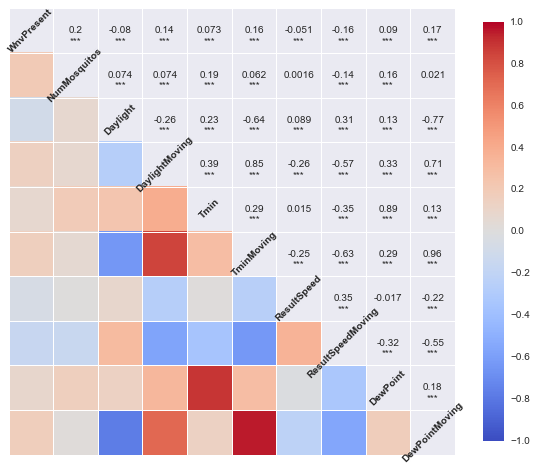

In [92]:
figsize(10, 10)
sns.corrplot(trapWeatherMoving[["WnvPresent", "NumMosquitos", "Daylight", "DaylightMoving",
                                "Tmin", "TminMoving", "ResultSpeed", "ResultSpeedMoving", 
                                "DewPoint", "DewPointMoving"]])
plt.show()

We're doing slightly better, it seems. Next, we'll plot some time series for a sanity check on how our rolling means correlate with NumMosquitos and WNV.

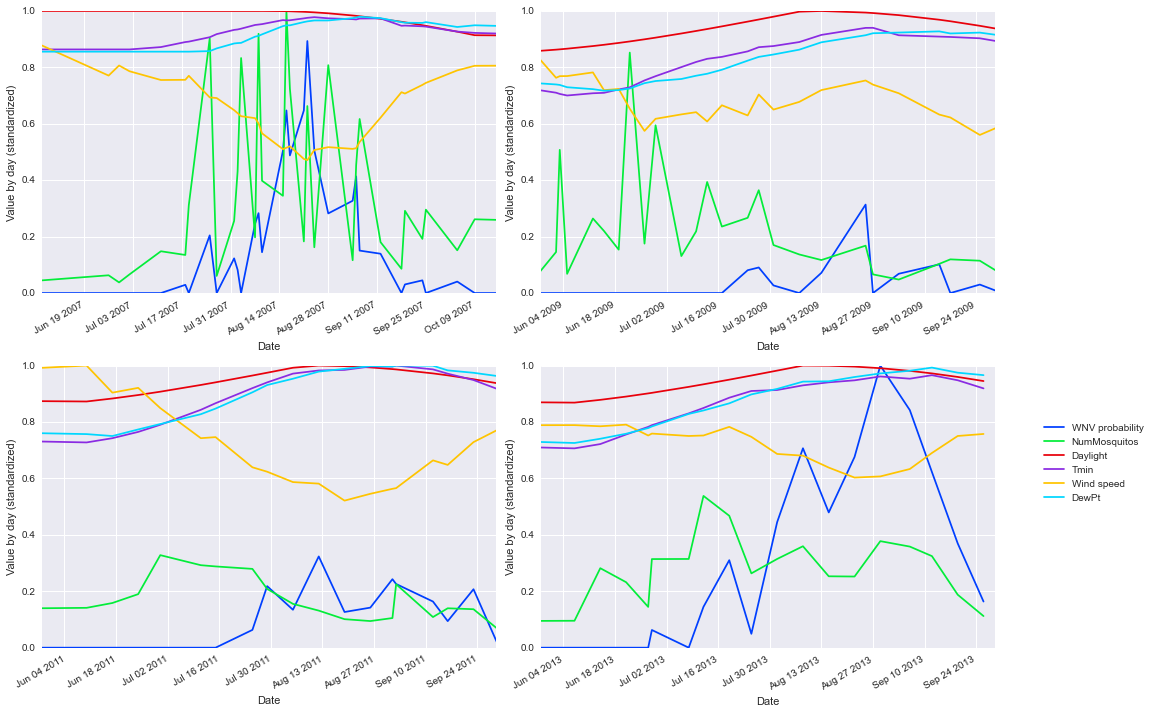

In [93]:
sns.set_palette("bright")

trapWeatherMovingByDay = trapWeatherMoving.groupby("Date")
df = trapWeatherMovingByDay # for brevity's sake
features = ["WnvPresent", "NumMosquitos", "DaylightMoving", 
             "TminMoving", "ResultSpeedMoving", "DewPointMoving"]

f, axes = plt.subplots(2, 2, figsize=(14,10))
j = 0
for ax in axes.ravel():
    for k in features:
        (df[k].mean()/df[k].mean().max()).plot(sharex=False, ax=ax, 
                                       xlim=(year_dates[j], year_dates[j+1]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Value by day (standardized)")
    j += 2

plt.legend(["WNV probability", "NumMosquitos", "Daylight", "Tmin", "Wind speed", "DewPt"], loc=(1.1,0.5))
plt.tight_layout()
plt.show()

The good news is that at the large-scale behaviors given by these rolling means now align reasonably well with WNV. What we've done, essentially, is replace the need for date as a variable by extracting the same information, if not better information, from the weather. The bad news is that we've smoothed out a lot of the small-scale variability in the process. WNV outbreaks are spiky, not smooth, affairs. If we want our model to have a low Type II error rate, we'll need it to be sensitive to these spikes.

Adding a simple time shift of highly correlated weather variables — in addition to our rolling means — might give us a way to account for both large-scale and small-scale structure. In wave language, we are starting to talk about superposing two different modes, and this suggests we take a look at Fourier transforms.  However, before we go too far down the rabbit hole building out our feature set, it would be wise to create an initial model and get a performance baseline. The only thing left to do is add species to our feature set.

### Species: additional features

Species is a categorical variable and requires transformation before we feed it into a model. 

In [94]:
# Add dummies for species
dummies = pd.get_dummies(trapWeatherMoving[["Species"]])
trapWeatherMovingDummies = trapWeatherMoving.join(dummies)
trapWeatherMovingDummies.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station,Tmax,Tmin,Tavg,...,DaylightMoving,PrecipTotalMoving,DewPointMoving,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506,10506.000000,10506.000000,10506.000000,...,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446,1,81.847992,62.716067,72.530459,...,14.287364,0.143630,55.330663,0.000095,0.256901,0.452313,0.260803,0.008186,0.000571,0.021131
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936,0,8.278380,7.677123,7.523979,...,0.587986,0.036374,4.924583,0.009756,0.436945,0.497744,0.439094,0.090109,0.023892,0.143827
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000,1,57.000000,41.000000,50.000000,...,12.719000,0.081400,44.494118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000,1,78.000000,58.000000,69.000000,...,13.942500,0.113600,52.458824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000,1,83.000000,64.000000,74.000000,...,14.447667,0.135800,56.552941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000,1,88.000000,69.000000,78.000000,...,14.811000,0.155900,59.564706,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000,1,96.000000,76.000000,84.000000,...,14.823833,0.252400,62.035294,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


--------------

##Model creation: first iteration

We now have a data set that is tidied up a bit and possesses some additional features for consideration. It's time to build a model and see how we do. We can add more features and do more complex transformation of our original features after this first pass.

### Setup

Let's separate our variables into distinct lists according to how promising they are as features. We'll then feed select features through a small set of models and see how different tunings do. Scikit-learn's GridSearchCV feature will be useful here and will save us the trouble of doing cross-validation. 

Now is also a good time to recall that we do **not** have access to NumMosquitos in our training set. For this reason, we'll exclude it as a feature of our initial model. Once we have done a decent search through the solution space, we can investigate how adding proxies for NumMosquitos affects our model's performance. At that point, we may want to return to the (decent but theoretically shaky) exponential fit from earlier.

In [95]:
# possible feature (sub)sets
good_vars = ["TminMoving", "DewPointMoving", "DaylightMoving", "ResultSpeedMoving"] + list(dummies.columns)

unmoving_vars = ["Tmin", "DewPoint", "Daylight", "ResultSpeed"]

spatial_vars = ["Latitude", "Longitude"]

unsure_vars = ["PrecipTotalMoving", "ResultDir"]

date_vars = ["Date"]

bad_vars = ["WnvPresent", "NumMosquitos", "Tavg", "Address", "Date", "Block", "Street", 
            "AddressNumberAndStreet", "Trap", "Species", "Tavg", "AvgSpeed", "Depart", 
            "CodeSum", "StnPressure", "SeaLevel", "Depth", "Water1", "SnowFall", "WetBulb", 
            "Heat", "Cool", "ResultDir", "Station", "Sunrise_float", "Sunset_float", 
            "AddressAccuracy", "Station", "Sunrise", "Sunset"]

In [96]:
# Labels data; this is what we're trying to predict
labels_data = np.array(trapWeatherMovingDummies['WnvPresent'])

In [97]:
# Import some useful packages
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [98]:
# Helper function for getting standardized array of desired features; pass in any concatenation of lists above
def feat_array(featlist, df=trapWeatherMovingDummies):
    f_array = np.array(df[featlist])
    f_data = preprocessing.StandardScaler().fit(f_array).transform(f_array)
    return f_data

### "Good" variables

We'll begin by running our most promising features through a select set of ML algorithms. Note that the `feat_array` helper function defined above standardizes all features using sklearn's `preprocessing` package. This normalization process should allow us not to flaunt too many assumptions of certain models.

In [99]:
features_data_1 = feat_array(good_vars)

In [100]:
X1_train, X1_test, y_train, y_test = train_test_split(
    features_data_1, labels_data, test_size = 0.50, random_state=42)

The classes of algorithms that seem most appropriate for our problem are:

* SVM classifier — SVMs work well for a variety of use cases. The caveats are that they are inherently linear, they struggle with non-normally distributed features, and they expect features to be uncorrelated. We don't expect our features to combine linearly, at least not necessarily, and we expect many of them to be correlated, so in the final analysis, we should expect SVM *not* to be the best choice. 
* k-nearest neighbors — A k-NN learner makes no assumptions about the distributions of the features, a fact that may help us with our unruly trap distributions and the general noisiness of WNV outbreaks. On the minus side, the notion of a distance metric in high-dimensional space is a bit fuzzy, and k-NN will suffer if we introduce additional features later. 
* Logistic regression — Logistic regression is a natural choice given the binary nature of the response variable. However, logistic regression models belong to the family of generalized linear models, and so, just as we should expect SVMs to be outperformed by some other shrewdly chosen model, we should expect logistic regression not to be the best choice at the end of the daay. 
* Decision trees — The highly skewed distributions that some of our trap data had and the seemingly non-linear relationships between most of our potential features and WNV suggest that a non-linear model is worth pursuing. Decision trees are simple and interpretable, and they work well with non-linear separation boundaries. The class imbalance may cause us trouble, however, and decision trees tend to have a high variance, so our DT classifier may not generalize well to entirely different years. Trying a tree-based ensemble method — random forest, bagging, or boosting — will be something to try after we nail down an initial error estimate for a single tree.

#### SVM classifiers

Below, we define model tunings as a list of dictionaries for use in grid search. We then select the best estimator, fit it against the data with our initial feature set, and make some predictions. Our performance metric is the ROC AUC score.

In [101]:
# Get the svm packages from sklearn
from sklearn import svm

# Parameter search space; use class_weight = "auto" to handle imbalanced classes
svm_tunings = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 
                     'C': [1, 10, 100], 'class_weight': ['auto']},
                    {'kernel': ['linear'], 'C': [1, 10, 100], 'class_weight': ['auto']},
                    {'kernel': ['poly'], 'degree': [1, 2, 3, 4], 
                     'C': [1, 10, 100], 'class_weight': ['auto']}]

# Train the model
svm_clf = GridSearchCV(svm.SVC(probability=True), svm_tunings, score_func=roc_auc_score, cv=10)
svm_clf.fit(X1_train, y_train)

# Our best estimator is...

print "Best estimator:", svm_clf.best_estimator_

svm_clf_pred = svm_clf.best_estimator_.predict_proba(X1_test)
print "AUC score:", roc_auc_score(y_test, svm_clf_pred[:, 1])

Best estimator: SVC(C=100, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='poly', max_iter=-1, probability=True,
  random_state=None, shrinking=True, tol=0.001, verbose=False)
AUC score: 0.802722905033


This is a decent score, but the choice of best estimator is a bit suspicious. The penalty term, C, of that estimator has a high value, and the kernel is a third-degree polynomial. Although we've done 10-fold cross-validation — that's what the `cv` parameter in GridSearchCV is doing — this feels like overfitting.

Let's have a look at the ROC curve.

In [102]:
# Helper function to plot ROC curve
def plot_roc_curve(pred):
    figsize(8, 6)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

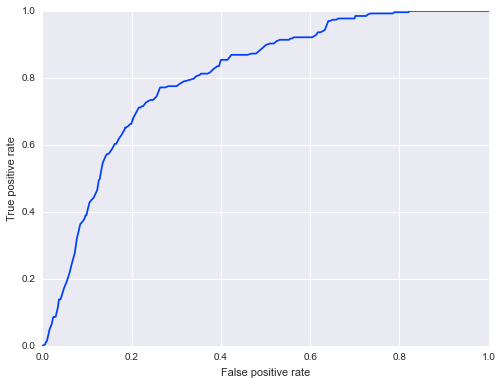

In [103]:
plot_roc_curve(svm_clf_pred)

#### k-nearest neighbors

We'll run through the same set of steps that we followed above for our other model contenders.

In [104]:
from sklearn.neighbors import KNeighborsClassifier

# Parameter search space; use class_weight = "auto" to handle imbalanced classes
knn_tunings = [{'weights': ['uniform', 'distance'], "n_neighbors": [1, 2, 3, 5, 10, 25, 50]}]

# Train the model
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_tunings, score_func=roc_auc_score, cv=10)
knn_clf.fit(X1_train, y_train)

# Best estimator
print "Best estimator:", knn_clf.best_estimator_

knn_clf_pred = knn_clf.best_estimator_.predict_proba(X1_test)
print "AUC score:", roc_auc_score(y_test, knn_clf_pred[:, 1])

Best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')
AUC score: 0.703029531377


This is notably worse than the SVM.

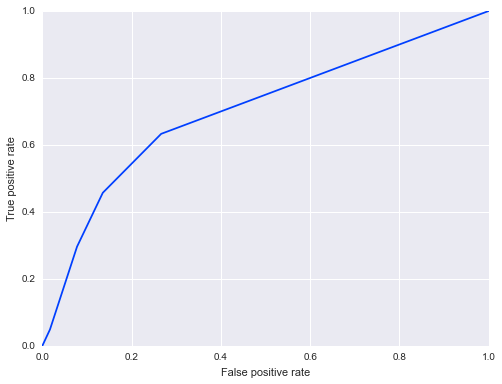

In [105]:
plot_roc_curve(knn_clf_pred)

#### Logistic regression

In [106]:
from sklearn import linear_model

lr_tunings = [{'C': [1, 10, 100, 1000], 'class_weight': ['auto']}]

lr_clf = GridSearchCV(linear_model.LogisticRegression(), lr_tunings, score_func=roc_auc_score, cv=10)
lr_clf.fit(X1_train, y_train)

# Our best estimator
print "Best estimator:", lr_clf.best_estimator_

lr_clf_pred = lr_clf.best_estimator_.predict_proba(X1_test)
print "AUC score:", roc_auc_score(y_test, lr_clf_pred[:, 1])

Best estimator: LogisticRegression(C=10, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)
AUC score: 0.799317114137


A comparable score to the SVM.

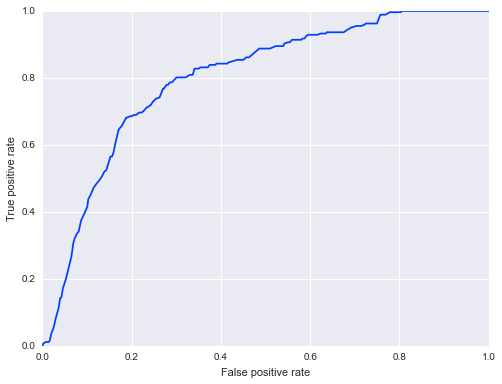

In [107]:
plot_roc_curve(lr_clf_pred)

#### Decision trees

In [108]:
from sklearn.tree import DecisionTreeClassifier

dt_tunings = [{"criterion": ["gini", "entropy"], "class_weight": ["auto"],
              "min_samples_split": [1, 2, 5, 10, 50], 
               "min_samples_leaf": [1, 2, 5, 10, 50]}]

dt_clf = GridSearchCV(DecisionTreeClassifier(), dt_tunings, score_func=roc_auc_score, cv=10)
dt_clf.fit(X1_train, y_train)

# Our best estimator
print "Best estimator:", dt_clf.best_estimator_

dt_clf_pred = dt_clf.best_estimator_.predict_proba(X1_test)
print "AUC score:", roc_auc_score(y_test, dt_clf_pred[:, 1])

Best estimator: DecisionTreeClassifier(class_weight='auto', criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
AUC score: 0.790879255924


Also comparable to the SVM.

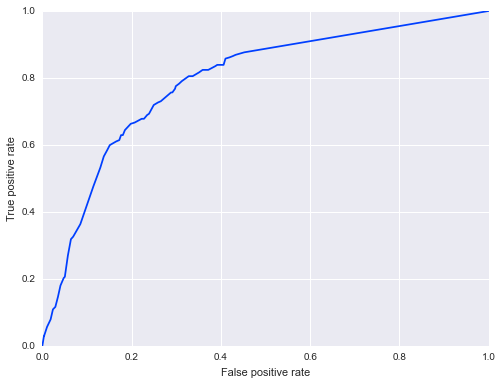

In [109]:
plot_roc_curve(dt_clf_pred)

#### Summary of "good" features

Our best-performing algorithm was the SVM, whose AUC score topped 0.8. We can consider this score *good* but hardly *excellent*. Getting to an acceptable sensitivity with the SVM entails too many false positives. (We don't want to send Chicago into a panic.) The logistic regression model and the decision tree did comparably well to the SVM. The k-nearest neighbors model fared worst. 

Let's have a look at all of the ROC curves for our initial models on the same plot.

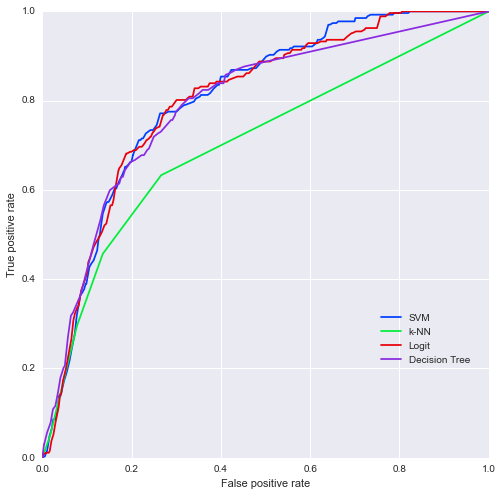

In [110]:
figsize(8, 8)

for k in [svm_clf_pred, knn_clf_pred, lr_clf_pred, dt_clf_pred]:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, k[:, 1])
    plt.plot(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["SVM", "k-NN", "Logit", "Decision Tree"], loc=(0.75,0.2))
plt.show()

Since k-nearest neighbors is likely to do even worse as we add more features, we have an argument for dropping it outright.

---
## Coming attractions / second iteration

We have several choices for how to proceed, including:

* Throw some additional features (e.g. lat/lon) into our first set of models
* Peek inside our initial models; in particular, consider adding interaction terms among correlated features 
* Run our initial feature set through different models — an ensemble learner such as a random forest, perhaps
* Add additional weather variables to get at small-timescale phenomena
* Try some trap-based clustering to get around having to add 100+ dummy dimensions
* Extract a proxy for NumMosquitos, using weather data and/or trap-based clustering

We'll try some of these ideas out in our next iteration. Stay tuned...